# Damped and periodically forced Duffing equation 


We consider the damped Duffing equation
$$
\dot{x}	=y, \dot{y}	=x-x^{3}-dy,
$$
with damping coefficient d=0.0141, and perform a change of coordinates 

$$\left(x,y\right)\mapsto\varphi=\left(\varphi_{1},\varphi_{2}\right)$$
that moves the stable focus at $(x,y)=(1,0)$ to the origin and makes the linear part block-diagonal. The resulting system is of the form

$$
\dot{\varphi}=A\varphi+f\left(\varphi\right),\qquad f\left(\varphi\right)=\mathcal{O}\left(\left|\varphi\right|^{2}\right),
$$
where
$$
A=\begin{pmatrix}-\alpha & -\omega\\
\omega & -\alpha
\end{pmatrix},\qquad\omega=1.4142,\quad\alpha=0.00707.
$$

## Analytic linearization

Here we will use the equations directly to construct the Taylor-series approximation of the linearization and its iverse. The computations are done symbolically with SymPy

We first perform the linear change of coordinates

In [2]:
import sympy as sy
import numpy as np
from scipy.integrate import solve_ivp
x, y, delta = sy.symbols('x y \delta', reals=True)
f1 = y
f2 = x - x**3 - delta*y
f = sy.Matrix([f1, f2])
f = f.subs(delta, 0.01*np.sqrt(2))
fps = sy.solve(f, [x, y], dict = True) # compute the fixed points 
Df = f.jacobian([x,y]).subs(fps[0])

vec = np.array(Df.eigenvects()[0][2][0], dtype=complex)
T = sy.Matrix(np.hstack((np.real(vec), np.imag(vec))))

In [3]:
sy.simplify(T.inv()@Df@T)

Matrix([
[-0.00707106781186548,    -1.41419588459308],
[    1.41419588459308, -0.00707106781186548]])

The forcing vector in physical coordinates is 
$$
\begin{pmatrix} 
0 \\ 1
\end{pmatrix}
$$
Transformed to the diagonalized coordinates:

In [4]:
T.inv()@sy.Matrix([0,1])

Matrix([
[-0.00612380090494769],
[    1.22474487139159]])

Define the new coordinates $\varphi$ as
$$
\begin{pmatrix}x \\ y\end{pmatrix} = T\varphi - \begin{pmatrix} -1 \\0 \end{pmatrix}
$$

In [5]:
z1, z2 = sy.symbols('z_1 z_2')
newcoords = sy.Matrix([z1, z2])
oldcoords = T@newcoords - sy.Matrix([-1, 0])

In [6]:
new_f = T.inv()@f.subs([(x, oldcoords[0]), (y, oldcoords[1])])

### Determine $\kappa^{-1}$

In [7]:

# Define the symbols
x, y, i, j = sy.symbols('x y i j')
maxorder = 7

# Define Indexed Bases
a = sy.IndexedBase('a')
b = sy.IndexedBase('b')

# Translate the summations
Y1 = sy.summation(a[i, j] * x**(i - 1) * y**(j - 1), (i, 1, maxorder + 1), (j, 1, maxorder + 1))
Y2 = sy.summation(b[i, j] * x**(i - 1) * y**(j - 1), (i, 1, maxorder + 1), (j, 1, maxorder + 1))

For the linearizing transformation, we assume that 

$$
\gamma_1 = \kappa^{-1}(\varphi)_1 = \sum_{i,j} a_{ij}\varphi_1^i \varphi_2^j
$$

and

$$
\gamma_2 = \kappa^{-1}(\varphi)_2 =\sum_{i,j} b_{ij}\varphi_1^i \varphi_2^j
$$


We then obtain the invariance equation by time-differentiation.

We have
$$
\frac{d}{dt}\gamma_1 = \frac{\partial \kappa^{-1}_1}{\partial \varphi_1} \dot{\varphi}_1 + \frac{\partial \kappa^{-1}_1}{\partial \varphi_2} \dot{\varphi}_2
$$
and at the same time
$$
\frac{d}{dt}\gamma_1 = -\alpha \gamma_1 - \omega \gamma_2.
$$

Therefore, the transformation must satisfy 

$$
-\alpha \kappa^{-1}(\varphi)_1 - \omega \kappa^{-1}(\varphi)_2 = \frac{\partial \kappa^{-1}_1}{\partial \varphi_1} \dot{\varphi}_1 + \frac{\partial \kappa^{-1}_1}{\partial \varphi_2} \dot{\varphi}_2
$$

We obtain the second component similarly.

$$
-\alpha \kappa^{-1}(\varphi)_1 + \omega \kappa^{-1}(\varphi)_2 = \frac{\partial \kappa^{-1}_2}{\partial \varphi_1} \dot{\varphi}_1 + \frac{\partial \kappa^{-1}_2}{\partial \varphi_2} \dot{\varphi}_2
$$

We will solve these equations order-by-order, for every order of $\varphi$.

In [8]:
# Substitutions for Y1
Y1_substituted = Y1.subs({a[1,1]: 0, 
                          a[2,1]: 1, 
                          a[1,2]: 0})

# Substitutions for Y2
Y2_substituted = Y2.subs({b[1,1]: 0, 
                          b[2,1]: 0, 
                          b[1,2]: 1})

In [9]:
from sympy import degree_list

def extract_up_to_n(expression, variables, Nmax):
    # Break the expression into a list of monomials
    monomials = expression.as_coefficients_dict()
    
    # Filter and sum the terms
    return sum(coeff * monomial for monomial, coeff in monomials.items() 
               if sum(sy.degree_list(monomial, *variables)[:len(variables)]) <= Nmax)


In [10]:
A = new_f.jacobian([z1,z2]).subs({z1: 0,
                            z2: 0})

In [11]:
Y1 =  extract_up_to_n(sy.expand(Y1_substituted), [x,y], maxorder)
Y2 =  extract_up_to_n(sy.expand(Y2_substituted), [x,y], maxorder)

In [12]:
udot = A[0,0] * Y1 + A[0,1] * Y2 # the linearized dynamics is enforced
vdot =  A[1,0] * Y1 + A[1,1] * Y2

In [13]:
ff = new_f.subs([(z1, x), (z2, y)])

In [14]:
L1 = Y1.diff(x)*ff[0] + Y1.diff(y)*ff[1]
L2 = Y2.diff(x)*ff[0] + Y2.diff(y)*ff[1]

R = [udot, vdot]

Create the invariance equations

In [15]:
eq1 = extract_up_to_n(sy.expand(R[0] - L1), [x,y], maxorder)
eq2 = extract_up_to_n(sy.expand(R[1] - L2), [x,y], maxorder)

In [16]:
def coefficient_list(expression, variables):
    poly = sy.Poly(expression, *variables)
    degrees = [poly.degree(var) for var in variables]
    coeffs = {}
    for i in range(degrees[0] + 1):
        for j in range(degrees[1] + 1):
            coeffs[(i, j)] = poly.coeff_monomial(variables[0]**i * variables[1]**j)
    return coeffs

In [17]:
coeff1 = coefficient_list(eq1, [x,y])
coeff2 = coefficient_list(eq2, [x,y])

In [18]:
# Function to extract variables from a dictionary of coefficients
def extract_variables(coeff_dict):
    return set().union(*[coeff.free_symbols for coeff in coeff_dict.values()])

# Extract variables from coeff1 and coeff2
variables1 = extract_variables(coeff1)
variables2 = extract_variables(coeff2)

# Extract variables from RHS
rhs_variables = set(ff.free_symbols)


# Calculate Coefficients1 and Coefficients2
Coefficients1 = variables1 - set(set((x, y)).union(rhs_variables)).union({a,b})
Coefficients2 = variables2 - ({x, y}.union(rhs_variables)).union({a,b})

# Combine the unique variables
cc = Coefficients1.union(Coefficients2)

In [19]:

Equations = []

for item in list(coeff1.items()):
    Equations.append(item[1])
for item in list(coeff2.items()):
    Equations.append(item[1])

# Equations is now a list of equations

In [20]:
symbols = []
for i in range(1,maxorder+1):
    for j in range(1,maxorder+1):

        if i + j < maxorder+1:
            symbols.append(a[i,j])
            symbols.append(b[i,j])

In [21]:
sol = sy.solve(Equations)
Y1_subbed = Y1.subs(sol)
Y2_subbed = Y2.subs(sol)


In [22]:
Y1_np = sy.lambdify([x,y], Y1_subbed)
Y2_np = sy.lambdify([x,y], Y2_subbed)


In [23]:
transformations = {}
transformations['gamma_1_phi1_phi2'] = Y1_subbed
transformations['gamma_2_phi1_phi2'] = Y2_subbed

transformations['gamma_1_phi1_phi2_numpy'] = Y1_np
transformations['gamma_2_phi1_phi2_numpy'] = Y2_np


### Determine $\kappa$

Now we seek 

$$
\varphi_1 = \kappa(\gamma)_1 = \sum_{i,j} \hat{a}_{ij}\gamma_1^i \gamma_2^j
$$

and

$$
\varphi_2 = \kappa(\gamma)_2 =\sum_{i,j} \hat{b}_{ij}\gamma_1^i \gamma_2^j
$$



The invariance equations can be obtained similarly as before

This transformation must satisfy 

$$
\dot{\varphi}_1 = \frac{\partial \kappa_1}{\partial \gamma_1} \left(-\alpha \gamma_1 - \omega \gamma_2 \right) + \frac{\partial \kappa_1}{\partial \gamma_2} \left(-\alpha \gamma_1 + \omega \gamma_2 \right)
$$
and
$$
\dot{\varphi}_2 = \frac{\partial \kappa_2}{\partial \gamma_1} \left(-\alpha \gamma_1 - \omega \gamma_2 \right) + \frac{\partial \kappa_2}{\partial \gamma_2} \left(-\alpha \gamma_1 + \omega \gamma_2 \right),
$$

where now $\dot{\varphi}$ is the right-hand side of the original, nonlinear ODE.



In [24]:


u, v, i, j = sy.symbols('u v i j')
maxorder = 7
# redefine the coefficients
a = sy.IndexedBase('a')
b = sy.IndexedBase('b')

Y1 = sy.summation(a[i, j] * u**(i - 1) * v**(j - 1), (i, 1, maxorder + 1), (j, 1, maxorder + 1))
Y2 = sy.summation(b[i, j] * u**(i - 1) * v**(j - 1), (i, 1, maxorder + 1), (j, 1, maxorder + 1))

In [25]:
# Substitutions for Y1
Y1_substituted = Y1.subs({a[1,1]: 0, 
                          a[2,1]: 1, 
                          a[1,2]: 0})

# Substitutions for Y2
Y2_substituted = Y2.subs({b[1,1]: 0, 
                          b[2,1]: 0, 
                          b[1,2]: 1})

In [26]:
Y1 =  extract_up_to_n(sy.expand(Y1_substituted), [u,v], maxorder)
Y2 =  extract_up_to_n(sy.expand(Y2_substituted), [u,v], maxorder)

In [27]:
udot = A[0,0] * u + A[0,1]*v
vdot =  A[1,0]*u + A[1,1] * v

In [28]:
L1 = Y1.diff(u)*udot + Y1.diff(v)*vdot
L2 = Y2.diff(u)*udot + Y2.diff(v)*vdot
R = sy.expand(ff.subs({x: Y1, 
    y : Y2}))

In [29]:
eq1 = extract_up_to_n(sy.expand(R[0] - L1), [u,v], maxorder)
eq2 = extract_up_to_n(sy.expand(R[1] - L2), [u,v], maxorder)

In [30]:
coeff1 = coefficient_list(eq1, [u,v])
coeff2 = coefficient_list(eq2, [u,v])

In [31]:

# Extract variables from coeff1 and coeff2
variables1 = extract_variables(coeff1)
variables2 = extract_variables(coeff2)

# Extract variables from RHS
rhs_variables = set(ff.free_symbols)


# Calculate Coefficients1 and Coefficients2
Coefficients1 = variables1 - set(set((u, v)).union(rhs_variables)).union({a,b})
Coefficients2 = variables2 - ({u, v}.union(rhs_variables)).union({a,b})

# Combine the unique variables
cc = Coefficients1.union(Coefficients2)

In [32]:
Equations = []

for item in list(coeff1.items()):
    Equations.append(item[1])
for item in list(coeff2.items()):
    Equations.append(item[1])

In [33]:
symbols = []
for i in range(1,maxorder+1):
    for j in range(1,maxorder+1):

        if i + j < maxorder+1:
            symbols.append(a[i,j])
            symbols.append(b[i,j])

In [34]:
sol = sy.solve(Equations)

In [35]:
Y1_subbed = Y1.subs(sol[0])
Y2_subbed = Y2.subs(sol[0])


In [36]:
Y1_np = sy.lambdify([u,v], Y1_subbed)
Y2_np = sy.lambdify([u,v], Y2_subbed)


In [37]:
transformations['phi1_1_gamma1_gamma2'] = Y1_subbed
transformations['phi2_2_gamma1_gamma2'] = Y2_subbed

transformations['phi_1_gamma1_gamma2_numpy'] = Y1_np
transformations['phi_2_gamma1_gamma2_numpy'] = Y2_np

### Estimating the radius of convergence 

For simplicity, instead of computing the radius of converggence from the coefficients of the Taylor-series, we estimate it using the point, at which a high-order approximation for the linearizing transformation breaks down. Since for the transformation $\kappa(\varphi)$, it has to hold that

$$
\kappa^{-1}\left(\kappa(\varphi)\right) = \varphi,
$$

we get a good approximation for the range of validity of the linearization by evaluating $\kappa^{-1}\left(\kappa(\varphi)\right)$. 

For example, along the diagonal $\varphi_1 = \varphi_2$ we obtain the following

In [38]:
import matplotlib.pyplot as plt

Text(0, 0.5, '$\\kappa^{-1} \\circ \\kappa$')

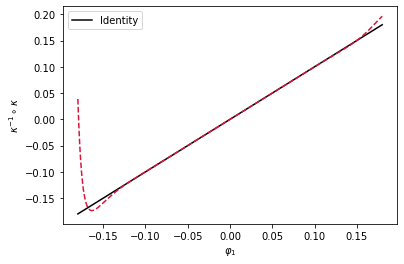

In [39]:
xx = np.linspace(-0.18, 0.18, 1000)

yy = np.squeeze(transformations['phi_1_gamma1_gamma2_numpy'](transformations['gamma_1_phi1_phi2_numpy'](xx, xx),
                                                            transformations['gamma_2_phi1_phi2_numpy'](xx, xx)))
plt.plot(xx, xx, '-', c= 'black', label = 'Identity')
plt.plot(xx, yy, '--', c='crimson')
plt.legend()
plt.xlabel(u'$\\varphi_1$')
plt.ylabel(u'$\\kappa^{-1} \\circ \\kappa$')


Therefore, we expect the dynamics to be analytically linearizable for 

$$
|\varphi|< R_{crit} \approx 0.15
$$

A more detailed analysis over a grid yields: 

In [40]:
xx = np.linspace(-0.3, 0.3, 200)

XX, YY = np.meshgrid(xx, xx)
phi1__XX = np.squeeze(transformations['phi_1_gamma1_gamma2_numpy'](transformations['gamma_1_phi1_phi2_numpy'](XX, YY),
                                                            transformations['gamma_2_phi1_phi2_numpy'](XX, YY)))

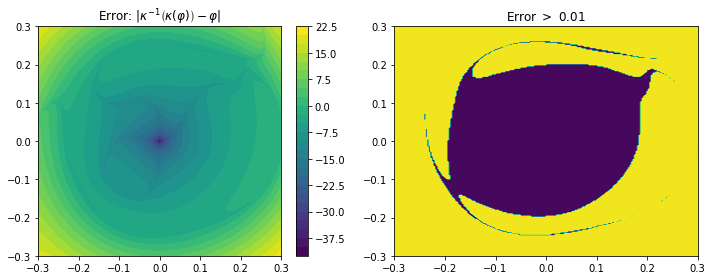

In [41]:
fig = plt.figure(figsize = (10, 4))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

cc = ax.contourf(XX, YY, np.log(np.abs(XX - phi1__XX)), 30)
ax.set_title(r'Error: $|\kappa^{-1}\left(\kappa(\varphi)\right) - \varphi|$')
plt.colorbar(cc)
cc = ax2.contourf(XX, YY, np.abs(XX - phi1__XX) > 0.01, 30)
ax2.set_title('Error $>$ 0.01')
plt.tight_layout()

### Comparison with DDL and DMD, EDMD

In [42]:
import numpy as np


In [43]:
import distinctipy
colors = distinctipy.get_colors(25, n_attempts = 1000, rng = 10, colorblind_type='Tritanopia')
#distinctipy.color_swatch(colors)


In [44]:
colors2 = distinctipy.get_colors(10, n_attempts = 7000, rng = 1, colorblind_type='Tritanopia')
#distinctipy.color_swatch(colors2)

In [45]:
ff_numpy = sy.lambdify([x, y], ff)

In [46]:
class Duffing_nonlinear:
    def __init__(self, eps, Omega):
        self.eps = eps
        self.Omega = Omega
        self.dimension = 2

    def dynamics(self, x0, t):

        """ODE system
        This function will be passed to the numerical integrator
        Inputs:
            x0: initial values
            t: time
        Outputs:
            x_dot: velocity vector
        """
        x1,x2 = x0
        vel_array = np.squeeze(ff_numpy(x1, x2)) + self.eps/np.sqrt(2) * np.array([1., 1.]) * np.cos(self.Omega*t)
        return np.array(vel_array)
    

In [47]:
A = np.array(A, dtype = float)

In [48]:
def lin_ode(t,x):
    return A@x

In [49]:
def toint(t,x, model):
    return model.dynamics(x,t)

In [50]:
tmax = 800

teval = np.linspace(0, tmax, 16000)

In [51]:
## compute the initial guess for A
v, w = np.linalg.eig(A)
dt = teval[1] - teval[0]
Diag_cont_init = np.diag(np.exp(v * dt))
init_matrix = np.real(w@Diag_cont_init@np.linalg.inv(w))

## Analysis of low amplitude data

In [52]:
low_amplitude_set = {}

In [53]:
ics_for_ddl = [[-0.12, 0.0013333], [0.125, 0.002], [-0.1115, 0.]]
ics_for_ddl_valid = [[-0.11, -0.02]]
ics_for_ddl_test = [[0.103, -0.02]]
omm = 1.6
model = Duffing_nonlinear( 0., omm)
period = 2 *np.pi / omm
converged = np.linspace(0, period, 100)
low_amplitude_set['train_data'] = [solve_ivp(toint, 
                                [0, tmax],
                                ic, t_eval = teval,
                                args = (model,)).y for ic in ics_for_ddl]
low_amplitude_set['validation_data'] = [solve_ivp(toint, 
                                [0, tmax],
                                ic, t_eval = teval,
                                args = (model,)).y for ic in ics_for_ddl_valid]
low_amplitude_set['test_data'] = [solve_ivp(toint, 
                                [0, tmax],
                                ic, t_eval = teval,
                                args = (model,)).y for ic in ics_for_ddl_test]

### Analytic prediction

In [54]:
from sklearn.preprocessing import PolynomialFeatures

In [55]:
def predict_linearization(x0, times):
    u0v0 = np.array([transformations['gamma_1_phi1_phi2_numpy'](*x0),
                     transformations['gamma_2_phi1_phi2_numpy'](*x0)])
    tmax = times[-1]
    sol = solve_ivp(lin_ode, 
                                [0, tmax],
                                u0v0, t_eval = times)
    return np.array([transformations['phi_1_gamma1_gamma2_numpy'](sol.y[0,:], sol.y[1,:]),
             transformations['phi_2_gamma1_gamma2_numpy'](sol.y[0,:], sol.y[1,:])])

In [56]:
linearized = predict_linearization(ics_for_ddl_valid[0], teval)

### EDMD, DMD

In [57]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 14,"font.family": "serif",})
plt.rcParams.update({'text.latex.preamble':r"\usepackage{amsmath}"})


In [58]:
%load_ext autoreload
%autoreload 2
%aimport datadrivenlinearization
deg = 5

In [59]:
deg = 5

In [60]:
dmd = datadrivenlinearization.DMD(low_amplitude_set['train_data'])
edmd = datadrivenlinearization.EDMD(low_amplitude_set['train_data'], degree = deg)

In [61]:

nonlin_features = PolynomialFeatures(degree = 5, 
                                     include_bias = False).fit_transform(low_amplitude_set['validation_data'][0].T)


In [62]:
def iterate(x0, A, n):
    iterates = [x0]
    for i in range(n):
        iterates.append(A@iterates[-1])
    return iterates

In [63]:
dmd_pred = np.array(iterate(ics_for_ddl_valid[0],
                            dmd.coef_, 
                            teval.shape[0] -1))

In [64]:
edmd_pred = np.array(iterate(nonlin_features[0,:],
                            edmd.coef_, 
                            teval.shape[0] -1))

In [65]:
figure_1 = {}

In [66]:
figure_1['teval'] = teval
figure_1['low_amplitude_set'] = low_amplitude_set['validation_data'][0]
figure_1['low_amplitude_linearized'] = linearized


In [67]:
figure_1['low_amplitude_dmd_pred'] = dmd_pred.T
figure_1['low_amplitude_edmd_pred'] = edmd_pred.T

### DDL

In [68]:
model = {}
d = datadrivenlinearization.DataDrivenLinearization(2, degree = 5, approximate = False)
loss = d.fit_lsq_inv(low_amplitude_set['train_data'], initial_matrix = init_matrix, 
           alpha = 0.,  method = 'trf', verbose = True)
model['ddl'] = d
inverse_transform, inverse_derivative, variables = datadrivenlinearization.differentiate_model_symbolic(
d.poly,
d.inverse_transformation_model.coef_)

transform, derivative, variables = datadrivenlinearization.differentiate_model_symbolic(
d.poly,
d.transformation_coefficients)


inverse_transform_numpy = sy.lambdify([variables], inverse_transform, 'numpy')
derivative_transform_numpy = sy.lambdify([variables], derivative, 'numpy')
transform_numpy = sy.lambdify([variables], transform, 'numpy')
inverse_derivative_transform_numpy = sy.lambdify([variables], inverse_derivative, 'numpy')
v, w = np.linalg.eig(d.linear_model)
dt = teval[1] - teval[0]
Diag_cont = np.diag(np.log(v) / dt)
Cont_non_diag = np.real(w@Diag_cont@np.linalg.inv(w))
dmd.coef_

Initial cost:  1.2314442963358525
     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-3.722e-06 -3.275e-06 ... -7.088e-11 -9.138e-11]
           x: [ 9.972e-01 -7.055e-02 ...  1.312e+01 -2.194e+01]
        cost: 2.937036279463389e-07
         jac: [[-1.218e-01  1.254e-02 ...  0.000e+00 -0.000e+00]
               [-1.224e-01  3.921e-03 ...  0.000e+00 -0.000e+00]
               ...
               [ 0.000e+00 -0.000e+00 ...  0.000e+00 -0.000e+00]
               [ 0.000e+00 -0.000e+00 ...  0.000e+00 -0.000e+00]]
        grad: [ 2.433e-09 -3.857e-09 ... -2.589e-14 -5.387e-14]
  optimality: 3.85660259163154e-09
 active_mask: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
        nfev: 51
        njev: 44
Final cost:  5.874072558926781e-07


array([[ 0.99716217, -0.07065283],
       [ 0.07023761,  0.99716588]])

In [69]:
valid_traj = low_amplitude_set['validation_data'][0]

transformed_valid = d.transform(valid_traj)
predicted_ddl = d.predict(valid_traj[:,0], valid_traj.shape[1]-1)
predicted_ddl = np.array(predicted_ddl)
predicted_ddl_trf = d.inverse_transform(np.array(predicted_ddl))

In [70]:
figure_1['low_amplitude_ddl_pred'] = predicted_ddl_trf
figure_1['low_amplitude_ddl_model'] = d

## Analysis of larger amplitude data

In [107]:
large_amplitude_set = {}

In [108]:
ics_for_ddl = [[-0.25, 0.0013333], [0.245, 0.002], [-0.25, 0.]]
ics_for_ddl_valid = [[-0.22, -0.02]]
ics_for_ddl_test = [[0.213, -0.02]]

model = Duffing_nonlinear( 0., omm)
period = 2 *np.pi / omm
converged = np.linspace(0, period, 100)
large_amplitude_set['train_data'] = [solve_ivp(toint, 
                                [0, tmax],
                                ic, t_eval = teval,
                                args = (model,)).y for ic in ics_for_ddl]
large_amplitude_set['validation_data'] = [solve_ivp(toint, 
                                [0, tmax],
                                ic, t_eval = teval,
                                args = (model,)).y for ic in ics_for_ddl_valid]
large_amplitude_set['test_data'] = [solve_ivp(toint, 
                                [0, tmax],
                                ic, t_eval = teval,
                                args = (model,)).y for ic in ics_for_ddl_test]

In [109]:
linearized = predict_linearization(ics_for_ddl_valid[0], teval)

In [110]:
figure_1['large_amplitude_set'] = large_amplitude_set['validation_data'][0]
figure_1['large_amplitude_linearized'] = linearized

In [111]:
dmd = datadrivenlinearization.DMD(large_amplitude_set['train_data'])
edmd = datadrivenlinearization.EDMD(large_amplitude_set['train_data'], degree = deg)

In [112]:

nonlin_features = PolynomialFeatures(degree = 5, 
                                     include_bias = False).fit_transform(large_amplitude_set['validation_data'][0].T)


In [113]:
dmd_pred = np.array(iterate(ics_for_ddl_valid[0],
                            dmd.coef_, 
                            teval.shape[0] -1))

In [114]:
edmd_pred = np.array(iterate(nonlin_features[0,:],
                            edmd.coef_, 
                            teval.shape[0] -1))

In [115]:
figure_1['large_amplitude_dmd_pred'] = dmd_pred.T
figure_1['large_amplitude_edmd_pred'] = edmd_pred.T

### DDL

In [116]:
model = {}
d= datadrivenlinearization.DataDrivenLinearization(2, degree = 5, approximate = False)
loss = d.fit_lsq_inv(large_amplitude_set['train_data'], initial_matrix = init_matrix, 
           alpha = 0,  method = 'trf', verbose = True)
model['ddl'] = d
inverse_transform, inverse_derivative, variables = datadrivenlinearization.differentiate_model_symbolic(
d.poly,
d.inverse_transformation_model.coef_)

transform, derivative, variables = datadrivenlinearization.differentiate_model_symbolic(
d.poly,
d.transformation_coefficients)


inverse_transform_numpy = sy.lambdify([variables], inverse_transform, 'numpy')
derivative_transform_numpy = sy.lambdify([variables], derivative, 'numpy')
transform_numpy = sy.lambdify([variables], transform, 'numpy')
inverse_derivative_transform_numpy = sy.lambdify([variables], inverse_derivative, 'numpy')
v, w = np.linalg.eig(d.linear_model)
dt = teval[1] - teval[0]
Diag_cont = np.diag(np.log(v) / dt)
Cont_non_diag = np.real(w@Diag_cont@np.linalg.inv(w))


Initial cost:  51.92232100748969
     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-2.616e-05 -1.803e-05 ...  5.191e-10  6.842e-10]
           x: [ 9.972e-01 -7.008e-02 ...  2.350e-01 -1.642e+00]
        cost: 1.768737353285405e-05
         jac: [[-2.616e-01  2.777e-02 ...  0.000e+00 -0.000e+00]
               [-2.628e-01  9.498e-03 ...  0.000e+00 -0.000e+00]
               ...
               [ 0.000e+00 -0.000e+00 ...  0.000e+00 -0.000e+00]
               [ 0.000e+00 -0.000e+00 ...  0.000e+00 -0.000e+00]]
        grad: [ 2.724e-09 -3.664e-09 ...  2.393e-13  4.010e-13]
  optimality: 3.664134923953897e-09
 active_mask: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
        nfev: 73
        njev: 58
Final cost:  3.537474706570808e-05


In [117]:
figure_1['teval'] = teval


In [118]:
valid_traj = large_amplitude_set['validation_data'][0]

transformed_valid = d.transform(valid_traj)
predicted_ddl = d.predict(valid_traj[:,0], valid_traj.shape[1]-1)
predicted_ddl = np.array(predicted_ddl)
predicted_ddl_trf = d.inverse_transform(np.array(predicted_ddl))

In [119]:
figure_1['large_amplitude_ddl_pred'] = predicted_ddl_trf
figure_1['large_amplitude_ddl_model'] = d

## Comparison figure

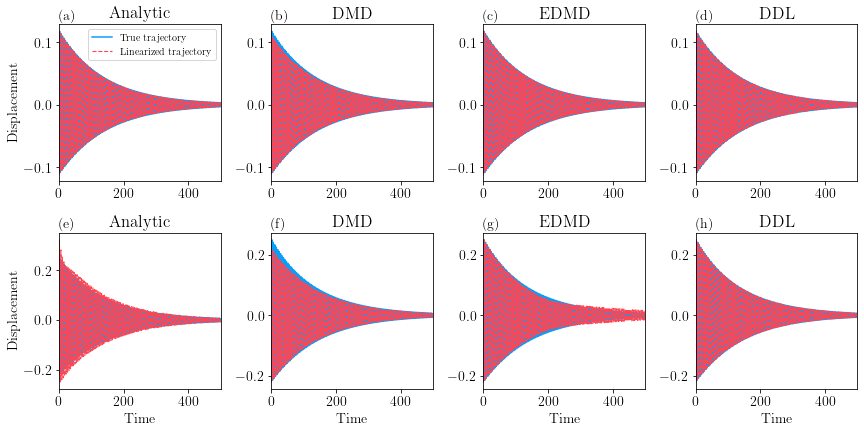

In [124]:
fig, axes = plt.subplots(ncols = 4, nrows = 2, figsize = (12,6))
axes[0,0].plot(figure_1['teval'], figure_1['low_amplitude_set'][0,:],  '-',
               linewidth = 1.5,  c=colors2[0], label = 'True trajectory')

axes[0,0].plot(figure_1['teval'], figure_1['low_amplitude_linearized'][0,:], '--', 
               linewidth = 1.1, alpha = 1, c=colors2[1], label = 'Linearized trajectory')
#axes[0,0].set_xlabel('Time')
#axes[0,0].set_ylabel('Displacement')
axes[0,0].set_title('Analytic')


axes[0,1].plot(figure_1['teval'], figure_1['low_amplitude_set'][0,:],  '-',
               linewidth = 1.5,  c=colors2[0])

axes[0,1].plot(figure_1['teval'], figure_1['low_amplitude_dmd_pred'][0,:], '--', 
               linewidth = 1.1, alpha = 1, c=colors2[1])
axes[0,1].set_title('DMD')


axes[0,2].plot(figure_1['teval'], figure_1['low_amplitude_set'][0,:],  '-',
               linewidth = 1.5,  c=colors2[0])

axes[0,2].plot(figure_1['teval'], figure_1['low_amplitude_edmd_pred'][0,:], '--', 
               linewidth = 1.1, alpha = 1, c=colors2[1])
axes[0,2].set_title('EDMD')


axes[0,3].plot(figure_1['teval'], figure_1['low_amplitude_set'][0,:],  '-',
               linewidth = 1.5,  c=colors2[0])

axes[0,3].plot(figure_1['teval'], figure_1['low_amplitude_ddl_pred'][0,:], '--', 
               linewidth = 1.1, alpha = 1, c=colors2[1])
axes[0,3].set_title('DDL')


axes[1,0].plot(figure_1['teval'], figure_1['large_amplitude_set'][0,:],  '-',
               linewidth = 1.5,  c=colors2[0], label = 'True trajectory')

axes[1,0].plot(figure_1['teval'], figure_1['large_amplitude_linearized'][0,:], '--', 
               linewidth = 1.1, alpha = 1, c=colors2[1], label = 'Linearized trajectory')
#axes[0,0].set_xlabel('Time')
#axes[0,0].set_ylabel('Displacement')
axes[1,0].set_title('Analytic')


axes[1,1].plot(figure_1['teval'], figure_1['large_amplitude_set'][0,:],  '-',
               linewidth = 1.5,  c=colors2[0])

axes[1,1].plot(figure_1['teval'], figure_1['large_amplitude_dmd_pred'][0,:], '--', 
               linewidth = 1.1, alpha = 1, c=colors2[1])
axes[1,1].set_title('DMD')


axes[1,2].plot(figure_1['teval'], figure_1['large_amplitude_set'][0,:],  '-',
               linewidth = 1.5,  c=colors2[0])

axes[1,2].plot(figure_1['teval'], figure_1['large_amplitude_edmd_pred'][0,:], '--', 
               linewidth = 1.1, alpha = 1, c=colors2[1])
axes[1,2].set_title('EDMD')


axes[1,3].plot(figure_1['teval'], figure_1['large_amplitude_set'][0,:],  '-',
               linewidth = 1.5,  c=colors2[0])

axes[1,3].plot(figure_1['teval'], figure_1['large_amplitude_ddl_pred'][0,:], '--', 
               linewidth = 1.1, alpha = 1, c=colors2[1])
axes[1,3].set_title('DDL')


for i in range(4):
    axes[0,i].set_xlim(0, 500)
#    axes[0,i].set_ylim(-0.045, 0.045)
    axes[1,i].set_xlim(0, 500)
 #   axes[1,i].set_ylim(-0.07, 0.07)

axes[0,0].legend(loc = 'upper right', fontsize = 10)
fig.tight_layout()
axes[0,0].set_ylabel('Displacement')
axes[1,0].set_ylabel('Displacement')


for i in range(4):
    axes[1,i].set_xlabel('Time')
    
    
    
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']
for a,l in zip(axes.ravel(), labels):
    a.text(0, 1.03, l,transform=a.transAxes)
plt.savefig('Duffing_many_cycles.pdf', bbox_inches='tight')

## Forced response curves

In [75]:

large_amplitude_ddl = d

In [76]:
inverse_transform, inverse_derivative, variables = datadrivenlinearization.differentiate_model_symbolic(
d.poly,
d.inverse_transformation_model.coef_)

transform, derivative, variables = datadrivenlinearization.differentiate_model_symbolic(
d.poly,
d.transformation_coefficients)

Generate the transformations as strings to better interface with COCO  https://sourceforge.net/p/cocotools/wiki/Home/

In [77]:
str(inverse_transform[0]).replace('**', '.^').replace('x_0', 'u').replace('x_1','v')

'-1.59289608601368*u.^5 - 1.85150594040478*u.^4*v + 0.428644233905906*u.^4 - 2.74962040713117*u.^3*v.^2 + 0.689053044967227*u.^3*v + 0.49350782436278*u.^3 - 2.95256299116598*u.^2*v.^3 + 0.931988255912053*u.^2*v.^2 - 1.43736661579682*u.^2*v + 0.283045775421371*u.^2 - 1.38304603549519*u*v.^4 + 0.72219971581533*u*v.^3 + 0.3897478431776*u*v.^2 + 0.00633682001607844*u*v + 1.0*u - 1.16222251806532*v.^5 + 0.515359436373895*v.^4 - 1.45393311007299*v.^3 + 0.579686866019628*v.^2'

In [78]:
str(inverse_transform[1]).replace('**', '.^').replace('x_0', 'u').replace('x_1','v')

'1.59725319981232*u.^5 - 2.00052579784532*u.^4*v - 0.838985010763412*u.^4 + 1.70512656023618*u.^3*v.^2 - 0.24537224995914*u.^3*v + 1.4266919733605*u.^3 - 3.45130627237694*u.^2*v.^3 - 0.0227299184546029*u.^2*v.^2 + 0.408448360935295*u.^2*v + 0.0061708709410077*u.^2 + 0.23494047288058*u*v.^4 - 0.185367955464875*u*v.^3 + 1.45200917631628*u*v.^2 - 0.58556431652207*u*v - 1.64231101465111*v.^5 + 0.823046383370391*v.^4 + 0.133252784041684*v.^3 + 0.00305917696132723*v.^2 + 1.0*v'

In [79]:
str(transform[0]).replace('**', '.^').replace('x_0', 'x').replace('x_1','y')

'-0.165256832103129*x.^5 - 0.515385501683801*x.^4*y + 0.198950587157329*x.^4 - 0.644775679129749*x.^3*y.^2 + 0.221897448895419*x.^3*y - 0.325783359836148*x.^3 - 1.1935195801907*x.^2*y.^3 - 0.0319751061834342*x.^2*y.^2 + 1.43756466989261*x.^2*y - 0.283805693543441*x.^2 - 0.287994429552663*x*y.^4 + 1.00540419764892*x*y.^3 - 0.733982662404922*x*y.^2 - 0.00647185817385574*x*y + 1.0*x - 1.02518921951131*y.^5 + 0.156136931765893*y.^4 + 1.46041380713414*y.^3 - 0.580132881019454*y.^2'

In [80]:
str(transform[1]).replace('**', '.^').replace('x_0', 'x').replace('x_1','y')

'-0.263173206163926*x.^5 - 0.154013292338289*x.^4*y + 1.16417753280445*x.^4 + 0.938571653860143*x.^3*y.^2 + 0.0277956130621576*x.^3*y - 1.41978792589119*x.^3 - 0.849659915485624*x.^2*y.^3 + 1.2603216538235*x.^2*y.^2 - 0.225070467970509*x.^2*y - 0.00535459533184467*x.^2 + 1.24769174453625*x*y.^4 - 0.339509384803092*x*y.^3 - 1.45387402580354*x*y.^2 + 0.583098396006681*x*y - 0.498021514325237*y.^5 + 0.910278554174954*y.^4 - 0.46866979501318*y.^3 - 0.00378757020645738*y.^2 + 1.0*y'

In [81]:
from scipy.io import loadmat

In [147]:
forced_response_data = loadmat('data/numeric_forced_response_physical.mat')


In [148]:
forced_response_data_analytic = loadmat('data/analytic_forced_response_physical.mat')


In [149]:
forced_response_data_leading_order = loadmat('data/numeric_forced_response_leading_ord_physical.mat')

In [150]:
max_amps_nonl = forced_response_data['max_amps']
max_amps_lin = forced_response_data['max_amps_linear']
max_amps_lin_leading_ord = forced_response_data_leading_order['max_amps_linear']


In [151]:
max_amps_nonl_analytic = forced_response_data_analytic['max_amps']
max_amps_lin_analytic = forced_response_data_analytic['max_amps_linear']


In [135]:
def linode(t,x, Mat, amp, freq):
    return Mat@x + amp * np.array([-0.006123800, 1.22474487]) * np.cos(freq * t) 

In [136]:
v, w = np.linalg.eig(dmd.coef_)
dt = teval[1] - teval[0]
Diag_cont_dmd = np.diag(np.log(v) / dt)
Cont_non_diag_dmd = np.real(w@Diag_cont@np.linalg.inv(w))


In [143]:
amplitudes = np.linspace(0.001, 0.006, 4)
omegas = np.linspace(1.2, 1.6, 400)
amplitudes = np.array([0.001,0.0022,0.0028,0.0035])
 

In [144]:
def generate_linear_response(ampl, omega):
    period = 2*np.pi / omega
    sol_tr = solve_ivp(linode, [0, 200*period], [0., 0.], args = (Cont_non_diag_dmd, ampl, omega,))
    resolved = np.linspace(0, period, 100)
    sol_full = solve_ivp(linode, [0, period], sol_tr.y[:,-1], t_eval=resolved,
                         args = (Cont_non_diag_dmd, ampl, omega))
    return sol_full
    

In [145]:
from tqdm import tqdm

In [146]:
linear_resp = []
for a in tqdm(amplitudes):
    linresp_1 = []
    for omm in omegas:
        sol = generate_linear_response(a, omm)
        linresp_1.append(np.abs(sol.y[0,:]).max())
    linear_resp.append(linresp_1)
linear_resp = np.array(linear_resp)

100%|█████████████████████████████████████████████| 4/4 [03:04<00:00, 46.23s/it]


In [96]:
colors2 = distinctipy.get_colors(10, n_attempts = 7000, rng = 1, colorblind_type='Tritanopia')
#distinctipy.color_swatch(colors2)

In [104]:
    freq = 2*np.pi/np.squeeze(max_amps_nonl[i,0])


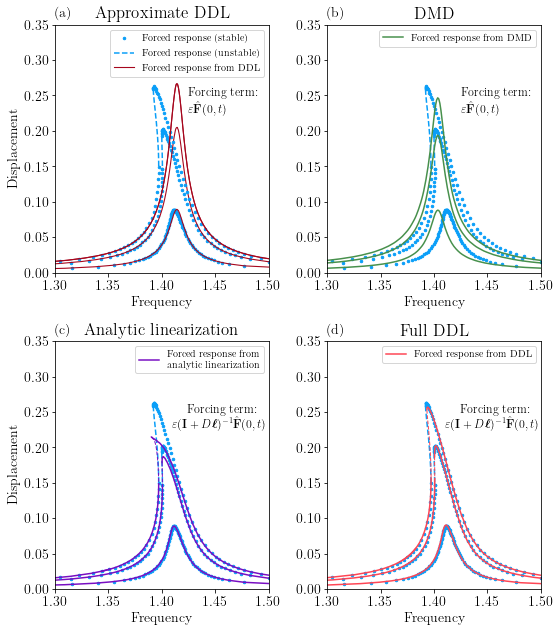

In [165]:
fig = plt.figure(figsize = (8,9))
ax = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax.set_xlim(1.3, 1.5)

ax2.set_xlim(1.3, 1.5)
ax3.set_xlim(1.3, 1.5)
ax4.set_xlim(1.3, 1.5)

ax.set_ylim(0, 0.35)
ax2.set_ylim(0, 0.35)
ax3.set_ylim(0, 0.35)
ax4.set_ylim(0, 0.35)

for i in range(4):
    freq = 2*np.pi/np.squeeze(max_amps_nonl[i,0])

    amp = np.squeeze(max_amps_nonl[i,1])
    stab = np.squeeze(max_amps_nonl[i,2])

    freq_stab = np.copy(freq)
    amp_stab = np.copy(amp)
    freq_stab[stab==0] = np.nan
    amp_stab[stab==0] = np.nan
    if i < 3:
        freq_leading_ord = 2*np.pi/np.squeeze(max_amps_lin_leading_ord[i,0])
        amp_leading_ord = np.squeeze(max_amps_lin_leading_ord[i,1])
    
    
    if i == 0:
        ax.plot(freq_stab, amp_stab, 'o',markersize = 2.5, c=colors2[0], label = 'Forced response (stable)')
        ax.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1.5, c=colors2[0],  label = 'Forced response (unstable)')
        ax2.plot(freq_stab, amp_stab, 'o',markersize = 2.5, c=colors2[0], )
        ax2.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1.5, c=colors2[0],)
        ax3.plot(freq_stab, amp_stab, 'o',markersize = 2.5, c=colors2[0], )
        ax3.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1.5, c=colors2[0],)
        ax4.plot(freq_stab, amp_stab, 'o',markersize = 2.5, c=colors2[0], )
        ax4.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1.5, c=colors2[0],)
    elif i < 3:
        ax.plot(freq_stab, amp_stab, 'o',markersize = 2.5, c=colors2[0],)
        ax.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1.5, c=colors2[0], )
        ax2.plot(freq_stab, amp_stab, 'o',markersize = 2.5, c=colors2[0],)
        ax2.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1.5, c=colors2[0],)
        ax3.plot(freq_stab, amp_stab, 'o',markersize = 2.5, c=colors2[0],)
        ax3.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1.5, c=colors2[0],)
        ax4.plot(freq_stab, amp_stab, 'o',markersize = 2.5, c=colors2[0],)
        ax4.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1.5, c=colors2[0],)
    
    
    
    
    freq = 2*np.pi/np.squeeze(max_amps_lin[i,0])
    amp = np.squeeze(max_amps_lin[i,1])
    stab = np.squeeze(max_amps_lin[i,2])
    freq_stab = np.copy(freq)
    amp_stab = np.copy(amp)
    if i < 3:
        freq_stab[stab==0] = np.nan
        amp_stab[stab==0] = np.nan
    if i == 0:
        ax4.plot(freq_stab, amp_stab, '-',linewidth = 1.5, c=colors2[1],label = 'Forced response from DDL')
        ax.plot(freq_leading_ord, amp_leading_ord, '-',linewidth = 1.1, c=colors2[5],label = 'Forced response from DDL')

    else:
        ax4.plot(freq_stab, amp_stab, '-',linewidth = 1.5, c=colors2[1],)
        ax.plot(freq_leading_ord, amp_leading_ord, '-',linewidth = 1.1, c=colors2[5])

    ax4.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1, c=colors2[1],)
    
    
    
    
    freq = 2*np.pi/np.squeeze(max_amps_lin_analytic[i,0])
    amp = np.squeeze(max_amps_lin_analytic[i,1])
    stab = np.squeeze(max_amps_lin_analytic[i,2])
    freq_stab = np.copy(freq)
    amp_stab = np.copy(amp)
    if i < 3:
        freq_stab[stab==0] = np.nan
        amp_stab[stab==0] = np.nan
    if i == 0:
        ax3.plot(freq_stab, amp_stab, '-',linewidth = 1.5, c=colors2[3],label = 'Forced response from \n analytic linearization')
    else:
#    elif i < 3:
        ax3.plot(freq_stab, amp_stab, '-',linewidth = 1.5, c=colors2[3],)
        ax3.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1, c=colors2[3],)
ax3.set_xlim(1.3, 1.5)
ax2.plot(omegas, linear_resp[0,:], '-', linewidth = 1.5, c=colors2[8], label = 'Forced response from DMD')



#ax3.plot(omegas, max_amps_lin_leading_ord[0,:], '-', linewidth = 1, c=colors2[8], label = 'Forced response from DMD')

for i in range(1,3):
    ax2.plot(omegas, linear_resp[i,:], '-', linewidth = 1.5, c=colors2[8])



ax.legend(fontsize=10)
ax2.legend(fontsize =10)
ax3.legend(fontsize =10)
ax4.legend(fontsize =10)


ax.set_xlabel('Frequency')
ax2.set_xlabel('Frequency')
ax3.set_xlabel('Frequency')
ax4.set_xlabel('Frequency')

ax.set_ylabel('Displacement')
ax3.set_ylabel('Displacement')

labels = ['(a)', '(b)', '(c)', '(d)']
for a,l in zip([ax, ax2, ax3, ax4], labels):
    a.text(0, 1.03, l, transform=a.transAxes)

ax4.text(1.41, 0.26,r"Forcing term: \\$\varepsilon(\mathbf{I} + D\boldsymbol{\ell})^{-1}\hat{\mathbf{F}}(0,t)$", fontsize = 12, ha = 'left', va = 'top')
ax3.text(1.41, 0.26,r"Forcing term: \\$\varepsilon(\mathbf{I} + D\boldsymbol{\ell})^{-1}\hat{\mathbf{F}}(0,t)$", fontsize = 12, ha = 'left', va = 'top')

ax.text(1.425, 0.26,"Forcing term: \n $\\centering{\\varepsilon\\hat{\mathbf{F}}(0,t)}$", fontsize = 12, ha = 'left', va = 'top')
ax2.text(1.425, 0.26,"Forcing term: \n $\\centering{\\varepsilon\\hat{\mathbf{F}}(0,t)}$", fontsize = 12, ha = 'left', va = 'top')
ax.set_title('Approximate DDL')
ax2.set_title('DMD')
ax3.set_title('Analytic linearization')
ax4.set_title('Full DDL')




fig.tight_layout()
plt.savefig('../figures_paper/Duffing_forced_response_comparison_physical.pdf', bbox_inches='tight')

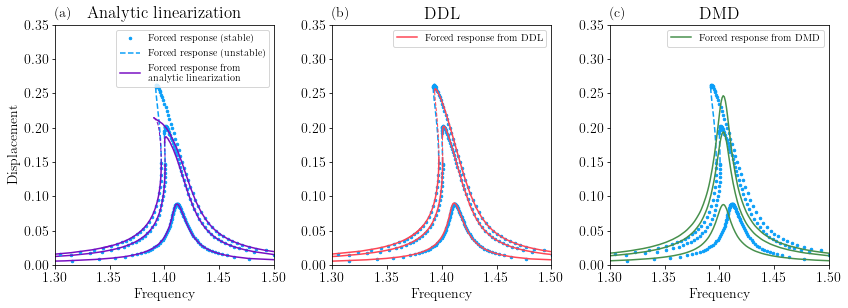

In [166]:
fig = plt.figure(figsize = (12,4.5))
ax = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

for i in range(4):
    freq = 2*np.pi/np.squeeze(max_amps_nonl[i,0])
    amp = np.squeeze(max_amps_nonl[i,1])
    stab = np.squeeze(max_amps_nonl[i,2])
    freq_stab = np.copy(freq)
    amp_stab = np.copy(amp)
    freq_stab[stab==0] = np.nan;
    amp_stab[stab==0] = np.nan
    if i < 3:
        freq_leading_ord = 2*np.pi/np.squeeze(max_amps_lin_leading_ord[i,0])
        amp_leading_ord = np.squeeze(max_amps_lin_leading_ord[i,1])
    
    
    if i == 0:
        ax.plot(freq_stab, amp_stab, 'o',markersize = 2.5, c=colors2[0], label = 'Forced response (stable)')
        ax.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1.5, c=colors2[0],  label = 'Forced response (unstable)')
        ax2.plot(freq_stab, amp_stab, 'o',markersize = 2.5, c=colors2[0], )
        ax2.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1.5, c=colors2[0],)
        ax3.plot(freq_stab, amp_stab, 'o',markersize = 2.5, c=colors2[0], )
        ax3.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1.5, c=colors2[0],)
    elif i < 3:
        ax.plot(freq_stab, amp_stab, 'o',markersize = 2.5, c=colors2[0],)
        ax.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1.5, c=colors2[0], )
        ax2.plot(freq_stab, amp_stab, 'o',markersize = 2.5, c=colors2[0],)
        ax2.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1.5, c=colors2[0],)
        ax3.plot(freq_stab, amp_stab, 'o',markersize = 2.5, c=colors2[0],)
        ax3.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1.5, c=colors2[0],)
    
    
    
    
    freq = 2*np.pi/np.squeeze(max_amps_lin[i,0])
    amp = np.squeeze(max_amps_lin[i,1])
    stab = np.squeeze(max_amps_lin[i,2])
    freq_stab = np.copy(freq)
    amp_stab = np.copy(amp)
    freq_stab[stab==0] = np.nan;
    amp_stab[stab==0] = np.nan
    if i == 0:
        ax2.plot(freq_stab, amp_stab, '-',linewidth = 1.5, c=colors2[1],label = 'Forced response from DDL')
    else:
        ax2.plot(freq_stab, amp_stab, '-',linewidth = 1.5, c=colors2[1],)


    ax2.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1, c=colors2[1],)
    
    
    
    
    freq = 2*np.pi/np.squeeze(max_amps_lin_analytic[i,0])
    amp = np.squeeze(max_amps_lin_analytic[i,1])
    stab = np.squeeze(max_amps_lin_analytic[i,2])
    freq_stab = np.copy(freq)
    amp_stab = np.copy(amp)
    freq_stab[stab==0] = np.nan;
    amp_stab[stab==0] = np.nan
    if i == 0:
        ax.plot(freq_stab, amp_stab, '-',linewidth = 1.5, c=colors2[3],label = 'Forced response from \n analytic linearization')
    else:
#    elif i < 3:
        ax.plot(freq_stab, amp_stab, '-',linewidth = 1.5, c=colors2[3],)
        ax.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1, c=colors2[3],)
ax3.set_xlim(1.3, 1.5)
ax3.plot(omegas, linear_resp[0,:], '-', linewidth = 1.5, c=colors2[8], label = 'Forced response from DMD')



#ax3.plot(omegas, max_amps_lin_leading_ord[0,:], '-', linewidth = 1, c=colors2[8], label = 'Forced response from DMD')

for i in range(1,3):
    ax3.plot(omegas, linear_resp[i,:], '-', linewidth = 1.5, c=colors2[8])


ax.set_xlim(1.3, 1.5)

ax2.set_xlim(1.3, 1.5)
ax3.set_xlim(1.3, 1.5)

ax.set_ylim(0, 0.35)
ax2.set_ylim(0, 0.35)
ax3.set_ylim(0, 0.35)

ax.legend(fontsize=10)
ax2.legend(fontsize =10)
ax3.legend(fontsize =10)


ax.set_xlabel('Frequency')
ax2.set_xlabel('Frequency')
ax3.set_xlabel('Frequency')

ax.set_ylabel('Displacement')

labels = ['(a)', '(b)', '(c)']
for a,l in zip([ax, ax2, ax3], labels):
    a.text(0, 1.03, l, transform=a.transAxes)


ax3.set_title('DMD')
ax.set_title('Analytic linearization')
ax2.set_title('DDL')




fig.tight_layout()
plt.savefig('../figures_paper/Duffing_forced_response_fullfig_physical.pdf', bbox_inches='tight')